In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nlp_utils
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import LdaModel
import gensim
import numpy as np
import pandas as pd
import logging
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/pavel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load parsed news dataset
dataset = nlp_utils.NewsTextDataset()
dataset.load("datasets/tokenized_dataset_2.json")

In [ ]:
# Preprocessing
dataset.preprocess()

In [4]:
data = dataset.dump_to_pandas()

In [5]:
data.head()

,category,tokenized_text
0,экономика,"[сооснователь, прошлый, многолетний, руководит..."
1,экономика,"[минэкономразвития, дорабатывать, вносить, пра..."
2,экономика,"[счет, который, открывать, российский, граждан..."
3,экономика,"[российский, рубль, являться, самый, недооцени..."
4,экономика,"[российский, онлайнкинотеатр, откладывать, нео..."


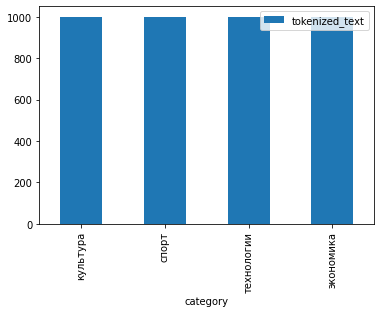

In [6]:
import matplotlib.pyplot as plt
data.groupby('category').count().plot.bar(ylim=0)
plt.show()

In [7]:
from gensim.corpora import Dictionary
def prep_corpus(docs, no_below=3, no_above=0.5):
    dictionary = Dictionary(docs)
    dictionary.compactify()
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
    dictionary.compactify()
    print('Creating corpus...')
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    return dictionary, corpus


#### Create corpus with BOW vectorizer

In [8]:
dictionary, corpus = prep_corpus(data['tokenized_text'])

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(39118 unique tokens: ['азия', 'американский', 'арканзас', 'бедный', 'безопасный']...) from 3999 documents (total 910807 corpus positions)
INFO:gensim.corpora.dictionary:discarding 23063 tokens: [('высокопродуктивный', 1), ('год', 3182), ('землевладелец', 1), ('земледелие', 1), ('игнорироваться', 1), ('который', 3260), ('луизиана', 1), ('мелинда', 2), ('небраска', 2), ('сахара', 2)]...
INFO:gensim.corpora.dictionary:keeping 16055 tokens which were in no less than 3 and no more than 1999 (=50.0%) documents
INFO:gensim.corpora.dictionary:resulting dictionary: Dictionary(16055 unique tokens: ['азия', 'американский', 'арканзас', 'бедный', 'безопасный']...)


Creating corpus...


#### Create  TFIDF model

In [9]:
from gensim import models

tfidf = models.TfidfModel(corpus, normalize=True)

INFO:gensim.models.tfidfmodel:collecting document frequencies
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #0
INFO:gensim.models.tfidfmodel:calculating IDF weights for 3999 documents and 16055 features (575468 matrix non-zeros)


In [10]:
corpus_tfidf = tfidf[corpus]

In [11]:
# Train the model on the TFIDF corpus
lda_tfidf = LdaModel(corpus_tfidf, 
               id2word=dictionary,
               num_topics=4,
               passes=50,
               iterations=50,
               decay=0.75,
               random_state=np.random.RandomState(42));

INFO:gensim.models.ldamodel:using symmetric alpha at 0.25
INFO:gensim.models.ldamodel:using symmetric eta at 0.25
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 4 topics, 50 passes over the supplied corpus of 3999 documents, updating model once every 2000 documents, evaluating perplexity every 3999 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/3999
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3999 documents
INFO:gensim.models.ldamodel:topic #0 (0.250): 0.002*"газпром" + 0.001*"нефть" + 0.001*"газ" + 0.001*"фильм" + 0.001*"рубль" + 0.001*"банк" + 0.001*"цена" + 0.001*"компания" + 0.001*"млрд" + 0.001*"россия"
INFO:gensim.models.ldamodel:topic #1 (0.250): 0.003*"нефть" + 0.002*"банк" + 0.002*"фильм" + 0.001*"доллар" + 0.001*"баррель" + 0.001*"млн" + 0.001*"рубль" + 0.001*"рост" + 0.0

In [ ]:
# Trying to add GridSearch
from gensim.test.utils import common_corpus, common_dictionary
from gensim.sklearn_api import LdaTransformer
from sklearn.model_selection import GridSearchCV
param_grid = {'num_topics': [4, 8, 16, 32],
               'passes': [10, 50, 100],
               'iterations':[50, 100, 500],
               'decay': [0.5, 0.75, 0.9]
               }
# Reduce each document to 2 dimensions (topics) using the sklearn interface.
model = LdaTransformer(id2word=dictionary)
sh = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=10).fit(corpus)

In [12]:
# Train the model on the BOW corpus.
lda = LdaModel(corpus, 
               id2word=dictionary,
               num_topics=4,
               passes=50,
               iterations=50,
               decay=0.75,
               random_state=np.random.RandomState(42))

INFO:gensim.models.ldamodel:using symmetric alpha at 0.25
INFO:gensim.models.ldamodel:using symmetric eta at 0.25
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 4 topics, 50 passes over the supplied corpus of 3999 documents, updating model once every 2000 documents, evaluating perplexity every 3999 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/3999
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3999 documents
INFO:gensim.models.ldamodel:topic #0 (0.250): 0.006*"россия" + 0.006*"компания" + 0.005*"весь" + 0.005*"российский" + 0.004*"мочь" + 0.004*"рубль" + 0.003*"заявлять" + 0.003*"сообщать" + 0.003*"фильм" + 0.003*"банк"
INFO:gensim.models.ldamodel:topic #1 (0.250): 0.006*"российский" + 0.005*"россия" + 0.004*"мочь" + 0.004*"нефть" + 0.004*"фильм" + 0.004*"весь" + 0.004*"доллар" + 0.

### Visalize result with BOW LDA model

In [13]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(lda, corpus, dictionary)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [14]:
pyLDAvis.display(vis_data)

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Visalize result with TFIDF LDA model

In [15]:
vis_data_tfidf = gensimvis.prepare(lda_tfidf, corpus_tfidf, dictionary)

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
pyLDAvis.display(vis_data_tfidf)

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
def generate_wordcloud(lda_model):
    for t in range(lda_model.num_topics):
        plt.figure()
        plt.imshow(WordCloud(background_color="white").fit_words(dict(lda_model.show_topic(t, 50))))
        plt.axis("off")
        plt.title("Topic #" + str(t))
        plt.show()

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Wordclouds for BOW LDA model

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


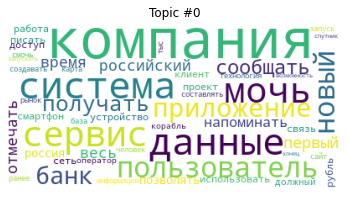

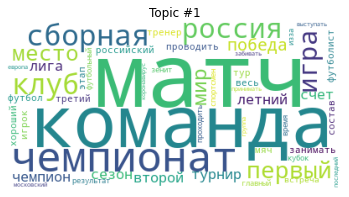

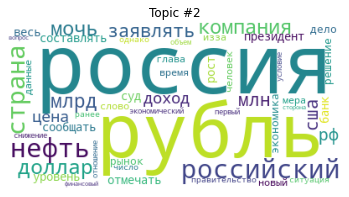

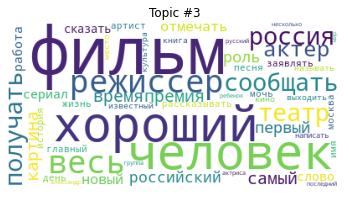

In [18]:
generate_wordcloud(lda)

### Wordcloud for TFIDF LDA model

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


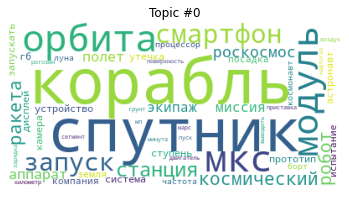

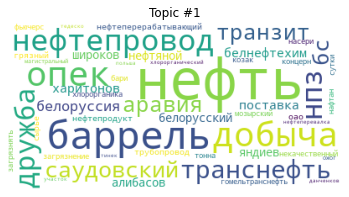

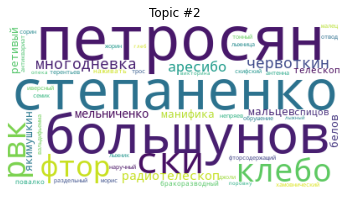

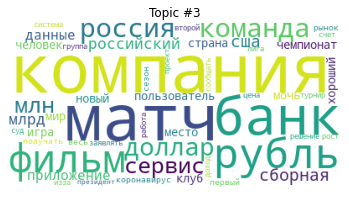

In [19]:
generate_wordcloud(lda_tfidf)

### Coherence Score Calculation for BOW LDA model

In [20]:
import gensim.downloader as api
from gensim.models.coherencemodel import CoherenceModel
w2v_model = api.load("word2vec-ruscorpora-300")

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:gensim.models.utils_any2vec:loading projection weights from /home/pavel/gensim-data/word2vec-ruscorpora-300/word2vec-ruscorpora-300.gz
INFO:gensim.models.utils_any2vec:loaded (184973, 300) matrix from /home/pavel/gensim-data/word2vec-ruscorpora-300/word2vec-ruscorpora-300.gz


In [21]:
cleaned_w2v_dict = {k.split('_')[0]: v for k, v in w2v_model.vocab.items()}
w2v_model.vocab = cleaned_w2v_dict

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
coherence_model_lda_w2v_bow = CoherenceModel(model=lda, texts=data['tokenized_text'], dictionary=dictionary, coherence='c_w2v',keyed_vectors=w2v_model)

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
coherence_lda = coherence_model_lda_w2v_bow.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5322943


/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Coherence Score Calculation for TFIDF LDA model

In [24]:
coherence_model_lda_w2v_tfidf = CoherenceModel(model=lda_tfidf, texts=data['tokenized_text'], dictionary=dictionary, coherence='c_w2v',keyed_vectors=w2v_model)

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
coherence_lda = coherence_model_lda_w2v_tfidf.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.5410596


## Task 3

In [26]:
data.category.unique()

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['экономика', 'культура', 'технологии', 'спорт'], dtype=object)

In [27]:
# Genereate input for word2vec
def generate_w2vec_distances(lda_model):
    true_topics = ['экономика', 'культура', 'технология', 'спорт']
    all_topic_words = []
    for topic_idx in range(lda_model.num_topics):
        topic_words = []
        for word, _ in lda_model.show_topic(topic_idx, 10):
            try:
                w2v_model.get_vector(word)
                topic_words.append(word)
            except KeyError as msg:
                print(msg)
                continue
        all_topic_words.append(topic_words)
    distances = [[w2v_model.distances(true_topic, generated_topic) for true_topic in true_topics] for generated_topic in all_topic_words]
    return np.array(distances)

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Plot distances for BOW LDA Model

In [47]:
distances_lba = generate_w2vec_distances(lda)

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
def plot_distances(distances):
    distances_mean = np.array([[np.mean(distances[i][j]) for j in range(distances.shape[0])] for i in range(distances.shape[1])])
    print(distances_mean.shape)
    fig, ax = plt.subplots()
    im = ax.imshow(distances_mean)

    ax.set_xticks(np.arange(distances_mean.shape[0]))
    ax.set_yticks(np.arange(distances_mean.shape[1]))
    ax.set_xticklabels(data.category.unique())
    ax.set_yticklabels([f'topic {i}' for i in range(distances_mean.shape[1])])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(distances_mean.shape[0]):
        for j in range(distances_mean.shape[1]):
            text = ax.text(j, i, round(distances_mean[i, j], 2),
                           ha="center", va="center", color="r")

    ax.set_title("Cosine similarities between true and predicted topics")
    fig.tight_layout()
    plt.show()

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4, 4)


/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


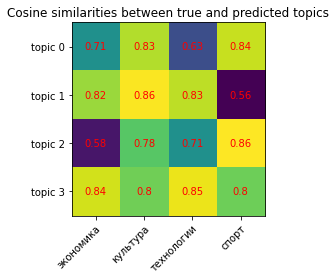

In [80]:
plot_distances(distances_lba)

## Plot distances for TF-IDF LDA Model

In [81]:
distances_lba_tf_idf = generate_w2vec_distances(lda_tfidf)

"word 'большунов' not in vocabulary"


/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4, 4)


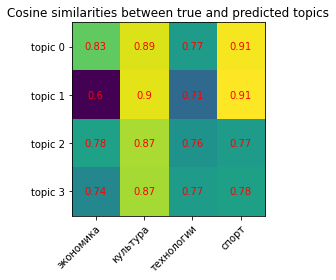

In [82]:
plot_distances(distances_lba_tf_idf)

## PLSA

In [85]:
from nltk.corpus import stopwords
from plsa.preprocessors import *

RUSSIAN_DEFAULT_PIPELINE = (
    tokenize,
    remove_short_words(2),
)

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
from plsa import Corpus, Pipeline, Visualize
from plsa.pipeline import DEFAULT_PIPELINE
from plsa.algorithms import PLSA
import csv
from numpy import zeros, ndarray, log, sign, abs
import matplotlib.pyplot as plt
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/pavel/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/pavel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [87]:
plsa_corpus_csv = data.copy()
for i, string in enumerate(plsa_corpus_csv['tokenized_text']):
    plsa_corpus_csv.iloc[i]['tokenized_text'] = ' '.join(string)

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
# plsa_corpus_csv['tokenized_text'] = plsa_corpus_csv['tokenized_text']
plsa_corpus_csv.to_csv('datasets/corpus.csv')

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
pipeline = Pipeline(*RUSSIAN_DEFAULT_PIPELINE)
corpus = Corpus.from_csv('datasets/corpus.csv', pipeline, col=-1, encoding='utf-8', max_docs=10000)
corpus

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Corpus:
Number of documents: 3999
Number of words:     39099

In [90]:
n_topics = 4

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
plsa = PLSA(corpus, n_topics, True)
plsa

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PLSA:
====
Number of topics:     4
Number of documents:  3999
Number of words:      39099
Number of iterations: 0

In [92]:
result = plsa.fit()

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
result.topic

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.2866634 , 0.27583449, 0.24343586, 0.19406625])

In [94]:
visualize = Visualize(result)
visualize

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Visualize:
Number of topics:    4
Number of documents: 3999
Number of words:     39099

In [95]:
result.word_given_topic[3][:10]

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(('корабль', 0.0036168961354451612),
 ('банк', 0.0035431494076264302),
 ('клиент', 0.003067375119193166),
 ('спутник', 0.00293528553594397),
 ('мкс', 0.0028450008557603665),
 ('система', 0.00284328604402223),
 ('утечка', 0.0027446161905620484),
 ('компания', 0.0027201026185584014),
 ('орбита', 0.002546584302575811),
 ('станция', 0.002413058989237784))

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


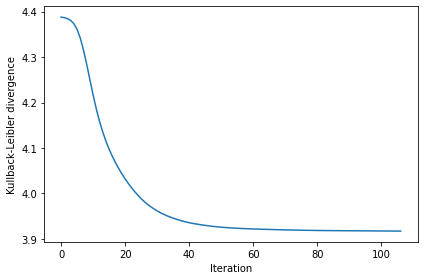

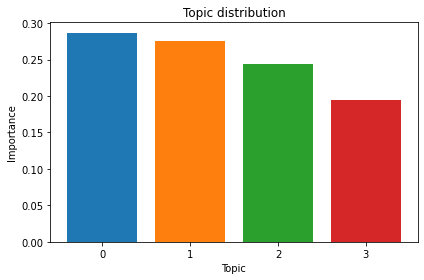

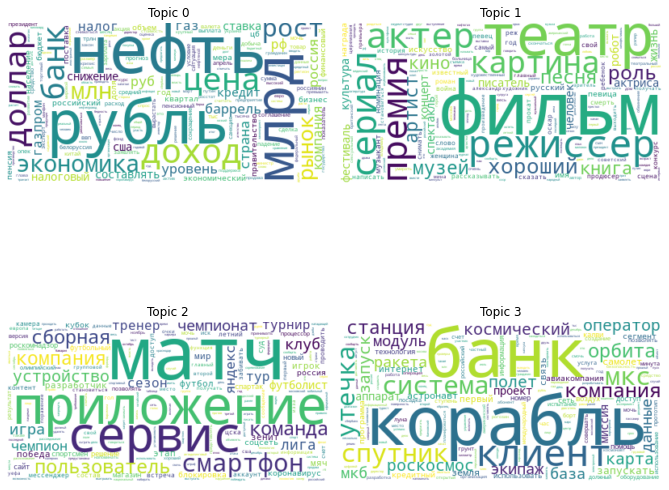

In [96]:
fig, ax = plt.subplots()
_ = visualize.convergence(ax)
fig.tight_layout()


fig, ax = plt.subplots()
_ = visualize.topics(ax)
fig.tight_layout()


fig = plt.figure(figsize=(9.4, 10))
_ = visualize.wordclouds(fig)



In [104]:
def generate_w2vec_distances_plsa(plsa_result):
    true_topics = ['экономика', 'культура', 'технология', 'спорт']
    all_topic_words = []
    for topic_idx in range(len(plsa_result.word_given_topic)):
        topic_words = []
        for word, _ in plsa_result.word_given_topic[topic_idx][:10]:
            try:
                w2v_model.get_vector(word)
                topic_words.append(word)
            except KeyError as msg:
                print(msg)
                continue
        all_topic_words.append(topic_words)
    distances = [[w2v_model.distances(true_topic, generated_topic) for true_topic in true_topics] for generated_topic in all_topic_words]
    return np.array(distances)

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
distances_plsa = generate_w2vec_distances_plsa(result)

/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4, 4)


/home/pavel/Labs/NLP/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


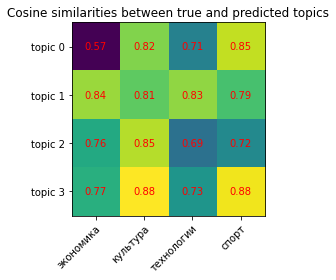

In [107]:
plot_distances(distances_plsa)